In [1]:
import ctypes
import numpy as np
from picosdk.ps4000a import ps4000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok

In [2]:
nwaveforms = 10
trig_chan = 0
trig_lev = 1 ## volts

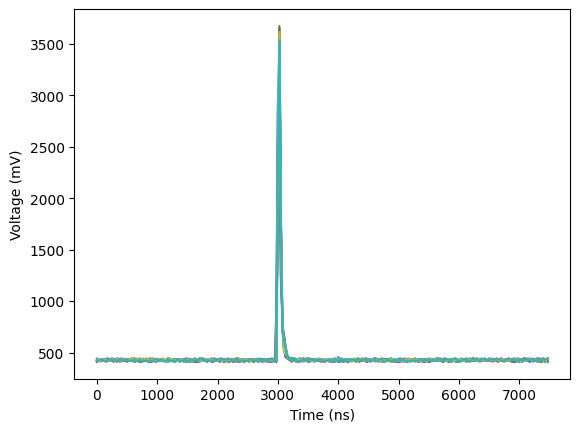

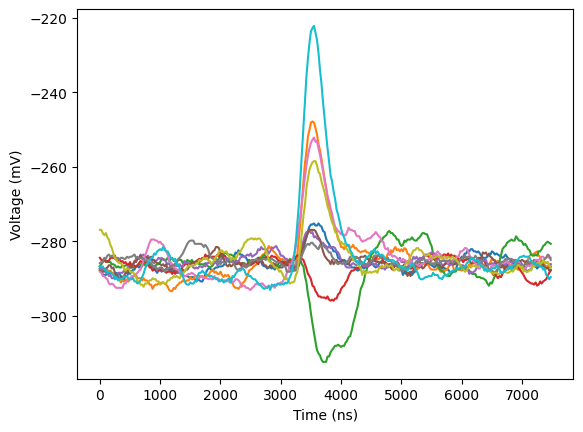

{'openunit': 0, 'setChA': 0, 'setChB': 0, 'setChC': 0, 'trigger': 0, 'getTimebase2': 0, 'setMemorySegments': 0, 'SetNoOfCaptures': 0, 'setDataBufferA0': 0, 'setDataBufferB0': 0, 'setDataBufferA1': 0, 'setDataBufferB1': 0, 'setDataBufferA2': 0, 'setDataBufferB2': 0, 'setDataBufferA3': 0, 'setDataBufferB3': 0, 'setDataBufferA4': 0, 'setDataBufferB4': 0, 'setDataBufferA5': 0, 'setDataBufferB5': 0, 'setDataBufferA6': 0, 'setDataBufferB6': 0, 'setDataBufferA7': 0, 'setDataBufferB7': 0, 'setDataBufferA8': 0, 'setDataBufferB8': 0, 'setDataBufferA9': 0, 'setDataBufferB9': 0, 'runBlock': 0, 'isReady': 0, 'getValuesBulk': 0, 'stop': 0, 'close': 0}


In [3]:
#
# Copyright (C) 2018 Pico Technology Ltd. See LICENSE file for terms.
#
# PS4824 BLOCK MODE EXAMPLE
# This example opens a 4000a driver device, sets up two channels and a trigger then collects a block of data.
# This data is then plotted as mV against time in ns.

# Create chandle and status ready for use
chandle = ctypes.c_int16()
status = {}

# Open 4000 series PicoScope
# Returns handle to chandle for use in future API functions
status["openunit"] = ps.ps4000aOpenUnit(ctypes.byref(chandle), None)

try:
    assert_pico_ok(status["openunit"])
except:

    powerStatus = status["openunit"]

    if powerStatus == 286:
        status["changePowerSource"] = ps.ps4000aChangePowerSource(chandle, powerStatus)
    else:
        raise

    assert_pico_ok(status["changePowerSource"])

# Set up channel A
# handle = chandle
# channel = PS4000a_CHANNEL_A = 0
# enabled = 1
# coupling type = PS4000a_DC = 1
# range = PS4000a_2V = 7
# analogOffset = 0 V
chARange = 10
status["setChA"] = ps.ps4000aSetChannel(chandle, 0, 1, 1, chARange, 0)
assert_pico_ok(status["setChA"])

# Set up channel B
# handle = chandle
# channel = PS4000a_CHANNEL_B = 1
# enabled = 1
# coupling type = PS4000a_DC = 1
# range = PS4000a_2V = 7
# analogOffset = 0 V
chBRange = 5
status["setChB"] = ps.ps4000aSetChannel(chandle, 1, 1, 1, chBRange, 0)
assert_pico_ok(status["setChB"])

# Set up channel C
# handle = chandle
# channel = PS4000a_CHANNEL_C = 2
# enabled = 1
# coupling type = PS4000a_DC = 1
# range = PS4000a_2V = 7
# analogOffset = 0 V
chCRange = 5
status["setChC"] = ps.ps4000aSetChannel(chandle, 2, 0, 1, chCRange, 0)
assert_pico_ok(status["setChC"])


# Set up single trigger
# handle = chandle
# enabled = 1
# source = PS4000a_CHANNEL_A = 0
# threshold = 1024 ADC counts
# direction = PS4000a_RISING = 2
# delay = 0 s
# auto Trigger = 1000 ms
status["trigger"] = ps.ps4000aSetSimpleTrigger(chandle, 1, 0, 3000, 2, 0, 100)
assert_pico_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected
preTriggerSamples = 120
postTriggerSamples = 180
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# WARNING: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle
# timebase = 8 = timebase
# noSamples = maxSamples
# pointer to timeIntervalNanoseconds = ctypes.byref(timeIntervalns)
# pointer to maxSamples = ctypes.byref(returnedMaxSamples)
# segment index = 0
timebase = 1
timeIntervalns = ctypes.c_float()
returnedMaxSamples = ctypes.c_int32()
oversample = ctypes.c_int16(1)
status["getTimebase2"] = ps.ps4000aGetTimebase2(chandle, timebase, maxSamples, ctypes.byref(timeIntervalns), ctypes.byref(returnedMaxSamples), 0)
assert_pico_ok(status["getTimebase2"])

# Set memory segments
# handle = chandle
# nSegments = 10
nMaxSamples = ctypes.c_int32(0)
status["setMemorySegments"] = ps.ps4000aMemorySegments(chandle, nwaveforms, ctypes.byref(nMaxSamples))
assert_pico_ok(status["setMemorySegments"])

status["SetNoOfCaptures"] = ps.ps4000aSetNoOfCaptures(chandle, nwaveforms)
assert_pico_ok(status["SetNoOfCaptures"])

## setup buffers
buffer_dict = {}
for j in range(nwaveforms):
    
    bufferA = (ctypes.c_int16 * maxSamples)()
    bufferB = (ctypes.c_int16 * maxSamples)()

    buffer_dict[j] = [bufferA, bufferB]

for j in range(nwaveforms):
    status["setDataBufferA" + str(j)] = ps.ps4000aSetDataBuffer(chandle, 0, ctypes.byref(buffer_dict[j][0]), maxSamples, j, 0)
    status["setDataBufferB" + str(j)] = ps.ps4000aSetDataBuffer(chandle, 1, ctypes.byref(buffer_dict[j][1]), maxSamples, j, 0)

# Run block capture
# handle = chandle
# number of pre-trigger samples = preTriggerSamples
# number of post-trigger samples = PostTriggerSamples
# timebase = 3 = 80 ns = timebase (see Programmer's guide for mre information on timebases)
# time indisposed ms = None (not needed in the example)
# segment index = 0
# lpReady = None (using ps4000aIsReady rather than ps4000aBlockReady)
# pParameter = None
status["runBlock"] = ps.ps4000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, None, 0, None, None)
assert_pico_ok(status["runBlock"])

# Check for data collection to finish using ps4000aIsReady
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
while ready.value == check.value:
    status["isReady"] = ps.ps4000aIsReady(chandle, ctypes.byref(ready))

# Create buffers ready for assigning pointers for data collection
#bufferAMax = (ctypes.c_int16 * maxSamples)()
#bufferAMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example
#bufferBMax = (ctypes.c_int16 * maxSamples)()
#bufferBMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example

# Set data buffer location for data collection from channel A
# handle = chandle
# source = PS4000a_CHANNEL_A = 0
# pointer to buffer max = ctypes.byref(bufferAMax)
# pointer to buffer min = ctypes.byref(bufferAMin)
# buffer length = maxSamples
# segementIndex = 0
# mode = PS4000A_RATIO_MODE_NONE = 0
#status["setDataBuffersA"] = ps.ps4000aSetDataBuffers(chandle, 0, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxSamples, 0 , 0)
#assert_pico_ok(status["setDataBuffersA"])

# Set data buffer location for data collection from channel B
# handle = chandle
# source = PS4000a_CHANNEL_B = 1
# pointer to buffer max = ctypes.byref(bufferBMax)
# pointer to buffer min = ctypes.byref(bufferBMin)
# buffer length = maxSamples
# segementIndex = 0
# mode = PS4000A_RATIO_MODE_NONE = 0
#status["setDataBuffersB"] = ps.ps4000aSetDataBuffers(chandle, 1, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxSamples, 0 , 0)
#assert_pico_ok(status["setDataBuffersB"])

# create overflow loaction
#overflow = ctypes.c_int16()
# create converted type maxSamples
#cmaxSamples = ctypes.c_int32(maxSamples)

# Creates a overlow location for data
overflow = (ctypes.c_int16 * nwaveforms)()
# Creates converted types maxsamples
cmaxSamples = ctypes.c_int32(maxSamples)

# Retried data from scope to buffers assigned above
# handle = chandle
# start index = 0
# pointer to number of samples = ctypes.byref(cmaxSamples)
# downsample ratio = 0
# downsample ratio mode = PS4000a_RATIO_MODE_NONE
# pointer to overflow = ctypes.byref(overflow))
#status["getValues"] = ps.ps4000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
#assert_pico_ok(status["getValues"])
status["getValuesBulk"] = ps.ps4000aGetValuesBulk(chandle, ctypes.byref(cmaxSamples), 0, 9, 1, 0, ctypes.byref(overflow))
assert_pico_ok(status["getValuesBulk"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16(32767)

data_dict = {}
# convert ADC counts data to mV
for j in range(nwaveforms):
    adc2mVChAMax =  adc2mV(buffer_dict[j][0], chARange, maxADC)
    adc2mVChBMax =  adc2mV(buffer_dict[j][1], chBRange, maxADC)

    data_dict[j] = [adc2mVChAMax, adc2mVChBMax]

# Create time data
time = np.linspace(0, (cmaxSamples.value - 1) * timeIntervalns.value, cmaxSamples.value)

# plot data from channel A and B
plt.figure()
for j in range(nwaveforms):
    plt.plot(time, data_dict[j][0])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')

plt.figure()
for j in range(nwaveforms):
    plt.plot(time, data_dict[j][1])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')

plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps4000aStop(chandle)
assert_pico_ok(status["stop"])

# Close unitDisconnect the scope
# handle = chandle
status["close"] = ps.ps4000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# display status returns
print(status)

In [4]:
status

{'openunit': 0,
 'setChA': 0,
 'setChB': 0,
 'setChC': 0,
 'trigger': 0,
 'getTimebase2': 0,
 'setMemorySegments': 0,
 'SetNoOfCaptures': 0,
 'setDataBufferA0': 0,
 'setDataBufferB0': 0,
 'setDataBufferA1': 0,
 'setDataBufferB1': 0,
 'setDataBufferA2': 0,
 'setDataBufferB2': 0,
 'setDataBufferA3': 0,
 'setDataBufferB3': 0,
 'setDataBufferA4': 0,
 'setDataBufferB4': 0,
 'setDataBufferA5': 0,
 'setDataBufferB5': 0,
 'setDataBufferA6': 0,
 'setDataBufferB6': 0,
 'setDataBufferA7': 0,
 'setDataBufferB7': 0,
 'setDataBufferA8': 0,
 'setDataBufferB8': 0,
 'setDataBufferA9': 0,
 'setDataBufferB9': 0,
 'runBlock': 0,
 'isReady': 0,
 'getValuesBulk': 0,
 'stop': 0,
 'close': 0}